### 인터넷 검색 후 기사를 작성하는 챗봇 만들기

사용자가 주제를 제시하면 인터넷을 검색하여 최신 이슈를 기반으로 세부 주제를 선정하고, 그 주제를 검색해서 최종 기사를 작성하는 신문기자 챗봇을 만들어보자.

#### 먼저 기사를 어떻게 작성할지 일의 순서를 설명한다.

너는 신문기자이다.  
최근 {about}에 대해 비판하는 심층 분석 기사를 쓰려고 한다.  

- 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘. 
- 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐. 
- 검색할 리스트를 토대로 재검색을 한다. 
- 목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해라.
- 검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋다. 

더 이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성하라.  
제목, 부제, 리드문, 본문 의 구성으로 작성하라. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이 있게 작성해야 한다.  

#### 현재 시간을 알려주는 함수와 웹 검색을 하는 함수를 랭체인의 도구로 등록하고 랭그래프로 구현

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")

True

In [2]:
# 언어 모델 설정
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-C59OdMJ0UoM2jqaiKQMwe1PnPfcjT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cd7b281-6f9b-4f8e-89dd-4caa628d7f3a-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [19]:
# 상태 설정하기
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):	# State 클래스는 TypedDict를 사용하여 딕셔너리 형태로 관리
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.   # messages라는 변수만 포함되며, 이는 Annoted를 사용해 문자열로 구성된 리스트 형식임
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.  # add_messages 함수를 추가. 이는 langgraph에서 제공하는 함수로, 문자열이 주어질 때 이를 추가하는 기능 수행
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]

# StateGraph 클래스를 사용하여 State 타입의 그래프를 생성합니다.
graph_builder = StateGraph(State)   # 생성한 State 를 이용해 StateGraph를 만들어 graph_builder라는 변수에 담는다.

In [6]:
# 도구 등록하기
from langchain_core.tools import tool
from datetime import datetime
import pytz
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

import bs4
from langchain_community.document_loaders import WebBaseLoader

# 도구 함수 정의
@tool
def get_current_time(timezone: str, location: str) -> str:
    """현재 시각을 반환하는 함수."""
    try:
        tz = pytz.timezone(timezone)
        now = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
        result = f'{timezone} ({location}) 현재시각 {now}'
        # print(result)
        return result
    except pytz.UnknownTimeZoneError:
        return f"알 수 없는 타임존: {timezone}"
    
@tool
def get_web_search(query: str, search_period: str='m') -> str:
    """
    웹 검색을 수행하는 함수.

    Args:
        query (str): 검색어
        search_period (str): 검색 기간 (e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)

    Returns:
        str: 검색 결과
    """
    wrapper = DuckDuckGoSearchAPIWrapper(
        # region="kr-kr", 
        time=search_period
    )

    print('\n-------- WEB SEARCH --------')
    print(query)
    print(search_period)

    search = DuckDuckGoSearchResults(
        api_wrapper=wrapper,
        # source="news",
        results_separator=';\n'
    )

    searched = search.invoke(query)
    
    for i, result in enumerate(searched.split(';\n')):
        print(f'{i+1}. {result}')
    
    return searched

# 도구 바인딩
tools = [get_current_time, get_web_search]

In [8]:
# 툴 테스트
tools[0].invoke({"timezone": 'Asia/Seoul', "location": '서울'})  # 현재 시각을 서울 시간으로 가져오기

'Asia/Seoul (서울) 현재시각 2025-08-16 20:34:17'

In [9]:
# 툴 테스트
tools[1].invoke({"query": '파이썬', "search_period": 'm'})


-------- WEB SEARCH --------
파이썬
m
1. snippet: The official home of the Python Programming Language, title: Welcome to Python.org, link: https://www.python.org/
2. snippet: 점프 투 파이썬: 위키독스의 내용을 엮어서 낸 파이썬 입문 서적. 기초적인 내용을 다루며 비전문가가 따라가기 쉽게 되어 있다., title: Python - 나무위키, link: https://namu.wiki/w/Python
3. snippet: 이 학습서를 읽은 후에는 파이썬 모듈과 프로그램을 읽고 쓸 수 있으며, 파이썬 표준 라이브러리 에 기술된 다양한 파이썬 라이브러리 모듈에 대해 배울 준비가 될 것입니다., title: 파이썬 자습서 — Python 3.13.6 문서, link: https://docs.python.org/ko/3/tutorial/index.html
4. snippet: 파이썬은 행복한 언어입니다. 파이썬 커뮤니티와 개발자들을 지원합니다., title: 파이썬 코리아, link: https://python.co.kr/


/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'snippet: The official home of the Python Programming Language, title: Welcome to Python.org, link: https://www.python.org/;\nsnippet: 점프 투 파이썬: 위키독스의 내용을 엮어서 낸 파이썬 입문 서적. 기초적인 내용을 다루며 비전문가가 따라가기 쉽게 되어 있다., title: Python - 나무위키, link: https://namu.wiki/w/Python;\nsnippet: 이 학습서를 읽은 후에는 파이썬 모듈과 프로그램을 읽고 쓸 수 있으며, 파이썬 표준 라이브러리 에 기술된 다양한 파이썬 라이브러리 모듈에 대해 배울 준비가 될 것입니다., title: 파이썬 자습서 — Python 3.13.6 문서, link: https://docs.python.org/ko/3/tutorial/index.html;\nsnippet: 파이썬은 행복한 언어입니다. 파이썬 커뮤니티와 개발자들을 지원합니다., title: 파이썬 코리아, link: https://python.co.kr/'

In [10]:
# 도구 목록 확인하기
for tool in tools:
    print(tool.name, tool)

get_current_time name='get_current_time' description='현재 시각을 반환하는 함수.' args_schema=<class 'langchain_core.utils.pydantic.get_current_time'> func=<function get_current_time at 0x7f2384104220>
get_web_search name='get_web_search' description='웹 검색을 수행하는 함수.\n\nArgs:\n    query (str): 검색어\n    search_period (str): 검색 기간 (e.g., "w" for past week (default), "m" for past month, "y" for past year, "d" for past day)\n\nReturns:\n    str: 검색 결과' args_schema=<class 'langchain_core.utils.pydantic.get_web_search'> func=<function get_web_search at 0x7f2384104860>


In [11]:
# 언어 모델에 .bind_tools로 사용할 도구 연결하기
model_with_tools = model.bind_tools(tools)

In [20]:
# 노드 생성하기
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.
		
    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리. 
          형식은 {"messages": [응답 메시지]}입니다.
    """ 
    return {"messages": [model_with_tools.invoke(state["messages"])]}

graph_builder.add_node("generate", generate)

In [21]:
# 도구를 사용하는 노드 클래스 생성하기
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """
    도구를 실행하는 노드 클래스입니다. 마지막 AIMessage에서 요청된 도구를 실행합니다.
    Attributes:
        tools_by_name (dict): 도구 이름을 키로 하고 도구 객체를 값으로 가지는 사전입니다.
    Methods:
        __init__(tools: list): 도구 객체들의 리스트를 받아서 초기화합니다.
        __call__(inputs: dict): 입력 메시지를 받아서 도구를 실행하고 결과 메시지를 반환합니다.
    """
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            # inputs에 messages가 있으면 messages를 가져오고 없으면 빈 리스트를 가져옵니다.
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": messages + outputs}

tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

##### 라우터 설정하기

generate 노드에서 인터넷 검색이나, 시간 확인이 필요하면 tools 노드에서 그 기능을 수행한 후 결과를 바탕으로 다시 generate 노드에 돌아와 답변을 생성할 수도 있다.

In [22]:
# START 에서 generate 까지는 이전과 같이 순차로 진행하고 generate 에서 언어 모델이 판단한 결과에 따라 경로가 달라지도록 설정한다.

def route_tools(state: State):
    """
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하고,
    그렇지 않은 경우 끝으로 라우팅하기 위해 conditional_edge에서 사용합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"tool_edge 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

#################
graph_builder.add_edge(START, "generate")

graph_builder.add_conditional_edges(
    "generate",
    route_tools,
    {"tools": "tools", END: END},
)

# 도구가 호출될 때마다 다음 단계를 결정하기 위해 챗봇으로 돌아갑니다.
graph_builder.add_edge("tools", "generate")
graph = graph_builder.compile()

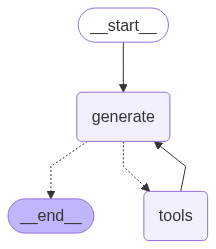

In [23]:
# 그래프 도식화하기
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    pass

In [24]:
# 테스트
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="지금 서울 몇시야?")]

gathered = None

for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')

        if gathered is None:
            gathered = msg
        else:
            gathered = gathered + msg

gathered

현재 서울은 2025년 8월 16일 20시 54분 40초입니다.

AIMessageChunk(content='현재 서울은 2025년 8월 16일 20시 54분 40초입니다.', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_vK7g5MDyyouO8i7UYWXH8VTo', 'function': {'arguments': '{"timezone":"Asia/Seoul","location":"서울"}', 'name': 'get_current_time'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_callsstop', 'model_name': 'gpt-4o-mini-2024-07-18gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559fp_560af6e559', 'service_tier': 'defaultdefault'}, id='run--72b8b7d4-63b0-4d79-a2aa-a97e88c0cc75', tool_calls=[{'name': 'get_current_time', 'args': {'timezone': 'Asia/Seoul', 'location': '서울'}, 'id': 'call_vK7g5MDyyouO8i7UYWXH8VTo', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'get_current_time', 'args': '{"timezone":"Asia/Seoul","location":"서울"}', 'id': 'call_vK7g5MDyyouO8i7UYWXH8VTo', 'index': 0, 'type': 'tool_call_chunk'}])

#### 프롬프트 설정하고 기사 작성하기

In [25]:
from langchain_core.messages import AIMessageChunk, SystemMessage

about = "서울월드컵 경기장 잔디 문제"

inputs = [SystemMessage(content=f"""
너는 신문기자이다. 
최근 {about}에 대해 비판하는 심층 분석 기사를 쓰려고 한다.  

- 최근 어떤 이슈가 있는지 검색하고, 사람들이 제일 관심있어 할만한 주제를 선정하고, 왜 선정했는지 말해줘. 
- 그 내용으로 원고를 작성하기 위한 목차를 만들고, 목차 내용을 채우기 위해 추가로 검색할 내용을 리스트로 정리해봐. 
- 검색할 리스트를 토대로 재검색을 한다. 
- 목차에 있는 내용을 작성하기 위해 더 검색이 필요한 정보가 있는지 확인하고, 있다면 추가로 검색해라.
- 검색된 결과에 원하는 정보를 찾지 못했다면 다른 검색어로 재검색해도 좋다. 

더 이상 검색할 내용이 없다면, 조선일보 신문 기사 형식으로 최종 기사를 작성하라.
제목, 부제, 리드문, 본문 의 구성으로 작성하라. 본문 내용은 심층 분석 기사에 맞게 구체적이고 깊이 있게 작성해야 한다. 
    
""")]

for msg, metadata in graph.stream({"messages": inputs}, stream_mode="messages"):
    if isinstance(msg, AIMessageChunk):
        print(msg.content, end='')


-------- WEB SEARCH --------
서울월드컵 경기장 잔디 문제
m


/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


1. snippet: Jul 31, 2025 · 잉글랜드 프리미어리그 (EPL) 뉴캐슬 유나이티드가 방한해 팀 K리그와 친선 경기를 치른 가운데 국내 축구장 '잔디 논란'이 또다시 고개를 들었다. 지난 30일 오후 경기 수원시 수원월드컵경기장에서는 '2025 쿠팡플레이 …, title: 선수도 "잔디 최악" 또 논란…4개월 만에 엉망 된 '빅버드', link: https://news.mt.co.kr/mtview.php?no=2025073108430354954
2. snippet: Jul 31, 2025 · 수원월드컵경기장은 지난 3월, 재개장을 앞두고 서울월드컵경기장의 상태가 좋지 않다는 이유로 요르단과의 3차 예선 홈경기를 개최했다. 이에 따라 수원은 서울 이랜드와의 코리아컵 2라운드 경기를 앞당겨서 치러야만 하는 …, title: 팀 K리그, 뉴캐슬에 1-0 승리... 또 불거진 수원월드컵경기장 잔디 ..., link: https://star.ohmynews.com/NWS_Web/OhmyStar/at_pg.aspx?CNTN_CD=A0003152984
3. snippet: Aug 2, 2025 · 뉴캐슬전 잔디 사태, 왜 발생했을까? 11억 들여 고친 수원 월드컵 경기장 잔디가 망가진 충격적인 이유를 깊이 파헤칩니다., title: 뉴캐슬전 잔디 대참사, 11억 들인 수원 경기장 잔디가 망가진 ..., link: https://koreaamateursports.tistory.com/entry/뉴캐슬전-잔디-대참사-11억-들인-수원-경기장-잔디가-망가진-충격적-이유
4. snippet: Jul 28, 2025 · 수원월드컵경기장관리재단은 잔디 회복을 위해 차양막을 사용하는 등 여러 조치를 취했다. 경기장 중앙 부근과 북측 페널티 박스 앞쪽이 훼손이 심해 이 부분 회복을 위해 집중적으로 노력한 것으로 알려졌다., title: [K리그2 이슈] 4개월 만에 상해버린 빅버드 잔디..."회복 불가능 ..., link: https://www.fmkorea.com/bes

/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


1. snippet: 5 days ago · 손흥민이 토트넘 소속으로 마지막 경기를 치른 서울월드컵경기장은 잔디 훼손으로 논란을 빚었던 곳이다., title: 손흥민 고별전에 잔디 불만 없었다…비판했던 축구팬 '엄지 척', link: https://www.newsis.com/view/NISX20250808_0003284340
2. snippet: Aug 8, 2025 · 지난 3일, 서울월드컵경기장에서 열린 '2025 쿠팡플레이 시리즈' 뉴캐슬 유나이티드와 토트넘 홋스퍼의 친선 경기를 다녀왔다. 이 경기는 손흥민 선수가 토트넘 소속으로 뛰는 마지막 …, title: [Opinion] 잔디, 뜯어가도 되나요? [공간], link: https://www.artinsight.co.kr/news/view.php?no=76896
3. snippet: Jul 31, 2025 · 수원월드컵경기장은 지난 3월 2026 국제축구연맹 (FIFA) 북중미 월드컵 아시아지역 3차예선을 치렀다. 당초 개최장이던 서울월드컵경기장 잔디 상태가 열악해 고양과 수원이 …, title: '빅버드 잔디'가 신음한다…조현우 이창민도 "뉴캐슬 힘들어 ..., link: https://sports.news.nate.com/view/20250731n07450
4. snippet: 2025년 8월 초, 서울월드컵경기장에서 열린 손흥민 선수의 은퇴 경기는 많은 이들의 눈시울을 적셨습니다. 하지만 경기가 끝난 후의 짧은 인터뷰 장면이 온라인상에서 다시 한번 뜨거운 논란의 …, title: 손흥민-데이비스 인터뷰 "우산 든 손 보니"..뒤늦게 온라인서 ..., link: https://m.blog.naver.com/plug_and_play_life/223960589861

-------- WEB SEARCH --------
축구 잔디 관리 체계
m


/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


1. snippet: 전북현대 21경기 무패도전, 직관 할 거지? 전주시 '축구버스'까지 준비했다, title: 축구 - 다음스포츠, link: https://sports.daum.net/soccer
2. snippet: 방문 중인 사이트에서 설명을 제공하지 않습니다., title: 스포츠홈 : 네이버 스포츠, link: https://sports.news.naver.com/kfootball/index.nhn
3. snippet: 축구 라이브 - 축구 경기 점수, 순위, 일정, 통계와 결과 아카이브. Livesport.com은 K-리그클래식부터 내셔널리그까지 모든 K-리그를 포함한 전 세계 1000개 이상의 경기에 관한 점수 서비스를 제공해드립니다., title: Livesport: 축구. 실시간 스코어, 결과, 순위, 통계, link: https://www.livesport.com/kr/soccer/
4. snippet: 야구 는 경기 중에 세세한 작전을 거는 경우가 축구보다 많지만, 기본적으로 투수와 타자의 일대일 대결이기 때문에 시즌 전체를 보면 감독이 팀 전술 전체에 미치는 영향력은 축구보다 적은 편이다., title: 축구 - 나무위키, link: https://namu.wiki/w/축구

-------- WEB SEARCH --------
잔디 문제로 인한 경기 사례
m
1. snippet: 메신저의 잠재력을 깨운 AI 협업툴 잔디는 맥락 요약, 향상된 정보 검색 그리고 생성으로 개인과 조직의 생산성을 한 번 더 끌어올립니다., title: 협업툴 잔디 (JANDI) - AI로 진화한 메신저 기반 업무용 협업툴, link: https://www.jandi.com/landing/kr
2. snippet: Apr 15, 2006 · 2. 난지형 (따뜻한 지역형) 잔디 종류 2-1. 들잔디 (Zoysia japonica) 한국 토종 잔디로, 공공장소에서 흔히 볼 수 있습니다. 특징 : 잎이 질기고 두껍고, 내구성이 뛰어남 장점 : 강한 …, title: 

/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


1. snippet: Justin Drew Bieber (/ ˈbiːbər / BEE-bər; born March 1, 1994) [1][2] is a Canadian singer and songwriter. Regarded as an influential figure in popular music, he is known for his multi-genre …, title: Justin Bieber - Wikipedia, link: https://en.wikipedia.org/wiki/Justin_Bieber
2. snippet: An intimate look at Justin Bieber’s life and music making process., title: Justin Bieber - YouTube, link: https://www.youtube.com/channel/UCIwFjwMjI0y7PDBVEO9-bkQ
3. snippet: 294M Followers, 902 Following, 8,199 Posts - Justin Bieber (@lilbieber) on Instagram: "@SKYLRK", title: Justin Bieber (@lilbieber) • Instagram photos and videos, link: https://www.instagram.com/lilbieber/
4. snippet: Justin Bieber is a Canadian pop star. Check this page to know everything about Justin Bieber - his career, hobbies, affairs, qualification, hometown & much more!, title: Justin Bieber Height, Age, Girlfriend, Wife, Family, Biography, link: https://starsunfolded.com/justin-bieber/
추가 검색 결과를 통해 오른 데이터를 정리했습니다

/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/home/haiqv/conda/envs/agent-llm/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


1. snippet: Oct 16, 2024 · 동행·매력 특별시 서울의 주요뉴스, 시민참여, 주요서비스, 참여 신청, 행사 및 축제, 자주찾은서비스, 시장실, 분야별정보, 새소식, 서울영상, 서울소식, 서울녹서등의 정보제공, title: 서울특별시 - 동행·매력 특별시 서울, link: http://seoul.go.kr/
2. snippet: 서울 은 (는) 여기로 연결됩니다. 다른 뜻에 대한 내용은 서울 (동음이의어) 문서를 참고하십시오. 대한민국광역자치단체 특별시 서울특별시 광역시 부산광역시 대구광역시 인천광역시 광주광역시 대전광역시 울산광역시 특별자치시 세종특별자치시 도 경기도 ..., title: 서울특별시 - 나무위키, link: https://namu.wiki/w/서울특별시
3. snippet: 서울 한양도성 조선시대 수도 한양을 둘러싸던 성곽으로, 도심 속에서 역사와 자연을 함께 느낄 수 있는 산책 명소 186 reviews, title: 서울 가볼만한 관광 명소 | 서울 공식 관광정보 웹사이트 - Seoul, link: https://korean.visitseoul.net/attractions
4. snippet: Jul 20, 2025 · 서울특별시 (서울特別市, 영어: Seoul Metropolitan City)는 사실상 대한민국 의 수도 이자 문화·인문·정치·경제 중심지 역할을 하는 도시로, 경기도 와 인천광역시 까지 아우르는 수도권 의 중심지 기능을 하고 있다., title: 서울특별시 - 위키백과, 우리 모두의 백과사전, link: https://ko.wikipedia.org/wiki/서울특별시

-------- WEB SEARCH --------
서울월드컵 경기장 잔디 관리 시스템
m
1. snippet: 동행·매력 특별시 서울의 주요뉴스, 시민참여, 주요서비스, 참여 신청, 행사 및 축제, 자주찾은서비스, 시장실, 분야별정보, 새소식, 서울영상, 서울소식, 서울녹서등의 정보제공, title: 서울특별시 - 동행·매력 특별시 서울, 